In this blog post, I'll show you how you can export your MLFlow data to a SQLite database so you can easily filter, search and aggregate all your Machine Learning experiments with SQL.

*Note:* You can get this post in notebook format from [here.](https://github.com/ploomber/mlflow2sql/blob/main/post/post.ipynb)

## The problem with MLFlow

MLFlow is one of the most widely used tools for experiment tracking, yet, its features for comparing experiments are severely limited. One basic operation I do with my Machine Learning experiments is to put plots side by side (e.g., confusion matrices or ROC curves); this simple operation isn't possible in MLFlow ([the issue](https://github.com/mlflow/mlflow/issues/2696) has been open since April 2020).

Another critical limitation are its filtering and search capabilities. MLFlow defines its own filter DSL which is a limited version of a [SQL WHERE clause](https://www.mlflow.org/docs/latest/search-runs.html). Even though MLFlow supports several SQL databases as backend, you have to use this limited DSL which only allows basic filtering but does not support aggregation or any other operation that you can trivially do with some lines of SQL. For me, this is a major drawback since often I want to perform more than a basic filter.

So let's see how we can get our data out of MLFlow and into a SQLite database so we can easily explore our Machine Learning experiments! Under the hood, this will use the [SQLiteTracker](https://sklearn-evaluation.readthedocs.io/en/latest/user_guide/SQLiteTracker.html) from the [sklearn-evaluation](https://github.com/ploomber/sklearn-evaluation) package.

## Setting up

The code is in a Python package that you can install with `pip`:

```sh
pip install mlflow2sql
```

## Optional: Generate sample data

If you don't have some sample MLFlow data, I wrote some utility functions to generate a few experiments and log them. However, you need to install a few extra dependencies:

```sh
pip install "mlflow2sql[demo]"
```

If you're running this from a notebook, you can run the following cel to install the dependencies:

In [1]:
%pip install "mlflow2sql[demo]" --quiet

Note: you may need to restart the kernel to use updated packages.


To generate some sample MLFlow data, run the following in a Python session (this will create the data in the `./mlflow-data` directory), this will take a few minutes:

In [1]:
import shutil
from pathlib import Path

from mlflow2sql import generate, export, ml

# clean up the directory, if any
path = Path("mlflow-data")
if path.exists():
    shutil.rmtree(path)    

# generate sample data
with generate.start_mlflow(backend_store_uri="mlflow-data",
                           default_artifact_root="mlflow-data"):
    ml.run_default()

[2022-12-21 14:28:49 -0600] [31007] [INFO] Starting gunicorn 20.1.0
[2022-12-21 14:28:49 -0600] [31007] [INFO] Listening at: http://127.0.0.1:5000 (31007)
[2022-12-21 14:28:49 -0600] [31007] [INFO] Using worker: sync
[2022-12-21 14:28:49 -0600] [31009] [INFO] Booting worker with pid: 31009
[2022-12-21 14:28:49 -0600] [31010] [INFO] Booting worker with pid: 31010
[2022-12-21 14:28:49 -0600] [31011] [INFO] Booting worker with pid: 31011
[2022-12-21 14:28:49 -0600] [31012] [INFO] Booting worker with pid: 31012


Training GradientBoostingClassifier...
Executed 10/30 so far...
Executed 20/30 so far...
Executed 30/30 so far...
Training SVC...
Executed 10/12 so far...
Training RandomForestClassifier...
Executed 10/54 so far...
Executed 20/54 so far...
Executed 30/54 so far...
Executed 40/54 so far...
Executed 50/54 so far...


[2022-12-21 14:32:29 -0600] [31007] [INFO] Handling signal: term
[2022-12-21 14:32:29 -0600] [31010] [INFO] Worker exiting (pid: 31010)
[2022-12-21 14:32:29 -0600] [31011] [INFO] Worker exiting (pid: 31011)
[2022-12-21 14:32:29 -0600] [31009] [INFO] Worker exiting (pid: 31009)
[2022-12-21 14:32:29 -0600] [31012] [INFO] Worker exiting (pid: 31012)
[2022-12-21 14:32:30 -0600] [31007] [INFO] Shutting down: Master


## Getting all MLFlow runs

Once you have some MLFlow data, start a Python session, define the `BACKEND_STORE_URI` and `DEFAULT_ARTIFACT_ROOT` variables in the next code snippet.


Note that the two variables correspond to the two arguments with the same name that you pass when starting the MLFlow server:

```sh
mlflow server --backend-store-uri BACKEND_STORE_URI --default-artifact-root DEFAULT_ARTIFACT_ROOT
```

*Note:* If you didn't pass those arguments when running `mlflow server`, the default value is `./mlruns`.

In [2]:
from mlflow2sql import export, ml

# these two variables are ./mlruns by default
BACKEND_STORE_URI = "mlflow-data"
DEFAULT_ARTIFACT_ROOT = "mlflow-data"

# note: this was tested with MLFlow versions 1.30.0 and 2.0.1
runs = export.find_runs(backend_store_uri=BACKEND_STORE_URI,
                        default_artifact_root=DEFAULT_ARTIFACT_ROOT)

We can get the number of experiments we extracted:

In [3]:
len(runs)

96

## Importing into a SQLite database

Let's now initialize our experiment tracker ([documentation available here](https://sklearn-evaluation.readthedocs.io/en/latest/user_guide/SQLiteTracker.html)), and insert our MLFlow experiments:

In [4]:
from sklearn_evaluation import SQLiteTracker

# clean up the database, if any
db = Path("experiments.db")

if db.exists():
    db.unlink()

tracker = SQLiteTracker('experiments.db')
tracker.insert_many((run.to_dict() for run in runs))

Let's check the number of extracted experiments:

In [5]:
len(tracker)

96

Great! We got all of them in the database. Let's start exploring them with SQL!

## Querying experiments with SQL

`SQLiteTracker` creates a table with all our experiments and it stores the logged data in a JSON object with three keys: `metrics`, `params`, and `artifacts`:

In [6]:
tracker.query("""
SELECT
    uuid,
    json_extract(parameters, '$.metrics') as metrics,
    json_extract(parameters, '$.params') as params,
    json_extract(parameters, '$.artifacts') as artifacts
    FROM experiments
LIMIT 3
""")

,metrics,params,artifacts
uuid,,,
42dc4d08,"{""recall"":[[""1671654737960""],[""0.8666260657734...","{""max_depth"":10,""model_name"":""RandomForestClas...","{""confusion_matrix_png"":""<img src=\""data:image..."
9cef8649,"{""recall"":[[""1671654632100""],[""0.8331303288672...","{""probability"":true,""model_name"":""SVC"",""C"":2.0...","{""confusion_matrix_png"":""<img src=\""data:image..."
053f4f97,"{""recall"":[[""1671654699203""],[""0.8623629719853...","{""max_depth"":10,""model_name"":""RandomForestClas...","{""confusion_matrix_png"":""<img src=\""data:image..."


We can extract the metrics easily. Note that MLFlow stores metrics in the following format:

```txt
(timestamp 1) (value 1)
(timestamp 2) (value 2)
```

Hence, when parsing it, we create two lists. One with the timestamps and another one with the values:

```python
[[ts1, ts2], [val1, val2]]
```

Let's extract the metrics values and sort by F1 score, note that `.query()` returns a `pandas.DataFrame` by default:

In [7]:
tracker.query("""
SELECT
    uuid,
    json_extract(parameters, '$.metrics.f1[1][0]') as f1,
    json_extract(parameters, '$.metrics.precision[1][0]') as precision,
    json_extract(parameters, '$.metrics.recall[1][0]') as recall,
    json_extract(parameters, '$.params.model_name') as model_name
FROM experiments
ORDER BY f1 DESC
LIMIT 10
""")

,f1,precision,recall,model_name
uuid,,,,
1fb0cd23,0.8040023543260741,0.7779043280182233,0.8319123020706456,RandomForestClassifier
07043ccb,0.8032883147386964,0.7755102040816326,0.833130328867235,RandomForestClassifier
b9a0c264,0.802570093457944,0.7710437710437711,0.8367844092570037,RandomForestClassifier
9dfec05b,0.8018675226145316,0.7697478991596639,0.8367844092570037,RandomForestClassifier
d14170de,0.8013998250218723,0.7688864017907107,0.8367844092570037,RandomForestClassifier
3da71d72,0.8005856515373354,0.7710095882684715,0.8325213154689404,RandomForestClassifier
cdccf858,0.7994358251057828,0.744613767735155,0.8629719853836785,RandomForestClassifier
461ec80d,0.7987475092513522,0.7498663816141101,0.8544457978075518,RandomForestClassifier
9cef8649,0.7981330221703616,0.7659574468085106,0.833130328867235,SVC


We can also extract the artifacts and display them inline by passing `as_frame=False` and `render_plots=True`:

In [8]:
results = tracker.query("""
SELECT
    uuid,
    json_extract(parameters, '$.metrics.f1[1][0]') as f1,
    json_extract(parameters, '$.params.model_name') as model_name,
    json_extract(parameters, '$.metrics.precision[1][0]') as precision,
    json_extract(parameters, '$.metrics.recall[1][0]') as recall,
    json_extract(parameters, '$.artifacts.confusion_matrix_png') as confusion_matrix,
    json_extract(parameters, '$.artifacts.precision_recall_png') as precision_recall
FROM experiments
ORDER BY f1 DESC
LIMIT 2
""", as_frame=False, render_plots=True)

results

## Displaying image artifacts

Looking at the plots is a bit difficult in the table view, but we can zoom in and extract them. Let's get a tab view from our top two experiments. Here are the confusion matrices:

In [9]:
results.get("confusion_matrix")

And here's the precision-recall curve:

In [10]:
results.get("precision_recall")

## Filtering and sorting

In our generated experiments, we trained some Support Vector Machines, Gradient Boosting and Random Forest. Let's filter by Random Forest, sort by F1 score and extract their parameters. We can easily do this with SQL!

In [11]:
tracker.query("""
SELECT
    uuid,
    json_extract(parameters, '$.metrics.f1[1][0]') as f1,
    json_extract(parameters, '$.params.model_name') as model_name,
    json_extract(parameters, '$.metrics.precision[1][0]') as precision,
    json_extract(parameters, '$.metrics.recall[1][0]') as recall,
    json_extract(parameters, '$.params.max_depth') as max_depth,
    json_extract(parameters, '$.params.n_estimators') as n_estimators,
    json_extract(parameters, '$.params.criterion') as criterion
FROM experiments
WHERE model_name = 'RandomForestClassifier'
ORDER BY f1 DESC
LIMIT 3
""", as_frame=False, render_plots=True)

uuid,f1,model_name,precision,recall,max_depth,n_estimators,criterion
1fb0cd23,0.8040023543260741,RandomForestClassifier,0.7779043280182233,0.8319123020706456,None,50,gini
07043ccb,0.8032883147386964,RandomForestClassifier,0.7755102040816326,0.833130328867235,None,50,log_loss
b9a0c264,0.802570093457944,RandomForestClassifier,0.7710437710437711,0.8367844092570037,None,100,entropy


## Aggregating and plotting

Finally, let's do something a bit more sophisticated. Let's get all the Random Forests, group by number of trees (`n_estimators`), and take the mean of our metrics. This will allow us to see what's the effect of increasing the number of trees in the model's perfomance:

In [12]:
df = tracker.query(
    """
SELECT
    json_extract(parameters, '$.params.n_estimators') as n_estimators,
    AVG(json_extract(parameters, '$.metrics.precision[1][0]')) as precision,
    AVG(json_extract(parameters, '$.metrics.recall[1][0]')) as recall,
    AVG(json_extract(parameters, '$.metrics.f1[1][0]')) as f1
FROM experiments
WHERE json_extract(parameters, '$.params.model_name') = 'RandomForestClassifier'
GROUP BY n_estimators
""",
    as_frame=True,
).set_index("n_estimators")

df

,precision,recall,f1
n_estimators,,,
5,0.712230,0.793071,0.749882
10,0.731649,0.792191,0.759146
15,0.727118,0.826228,0.772904
25,0.734089,0.841318,0.783521
50,0.738559,0.846461,0.788263
100,0.735830,0.849303,0.788023


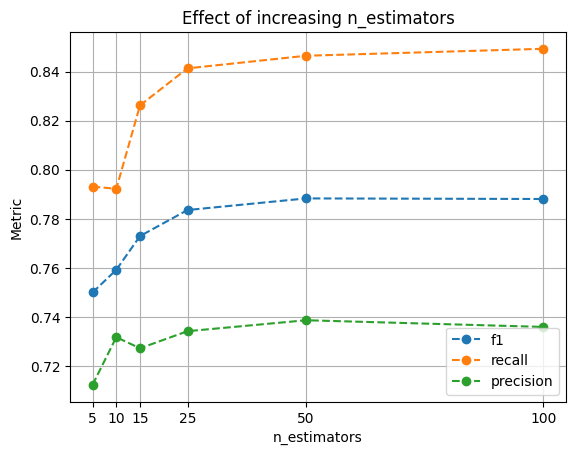

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for metric in ["f1", "recall", "precision"]:
    df[metric].plot(ax=ax, marker="o", style="--")

ax.legend()
ax.grid()
ax.set_title("Effect of increasing n_estimators")
ax.set_ylabel("Metric")
_ = ax.set_xticks(df.index)

We can see that the increase in performance diminishes rapidly, after 50 estimators, there isn't much performance gain. This analysis allows us to find these type of insights and focus on other parameters for improving performance.

Finally, let's group by model type and see how our models are doing on average:

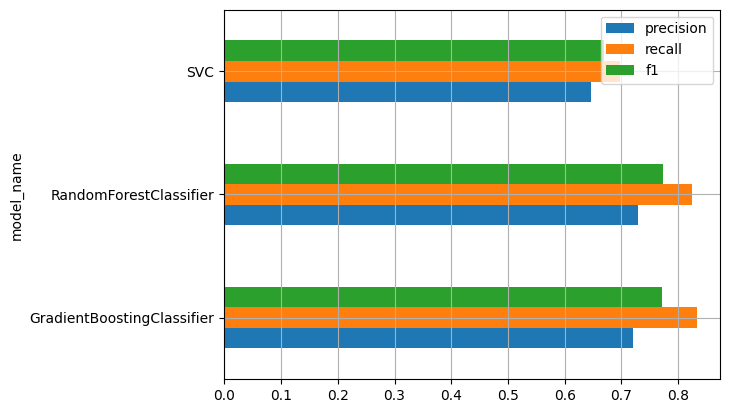

In [14]:
df = tracker.query(
    """
SELECT
    json_extract(parameters, '$.params.model_name') as model_name,
    AVG(json_extract(parameters, '$.metrics.precision[1][0]')) as precision,
    AVG(json_extract(parameters, '$.metrics.recall[1][0]')) as recall,
    AVG(json_extract(parameters, '$.metrics.f1[1][0]')) as f1
FROM experiments
GROUP BY model_name
""",
    as_frame=True,
).set_index("model_name")

ax = plt.gca()
df.plot(kind="barh", ax=ax)
ax.grid()

We see that Random Forest and Gradient Boosting have comparable performance, on average (although take into account that we ran more Random Forest experiments), and SVC has lower performance.

## Closing remarks

In this blog post, we showed how to export MLFlow data to a SQLite database, which allows us to use SQL to explore, aggregate and analyze our Machine Learning experiments, a lot better than MLFlow's limited querying capabilities!

There are a few limitations to this first implementation, it'll only work if you're using the local filesystem for storing your MLFlow experiments and artifacts. And only `.txt`, `.json` and `.png` artifacts are supported. If you have any suggestions, feel free to open an issue on [GitHub](https://github.com/ploomber/mlflow2sql), or send us a message on [Slack!](https://ploomber.io/community/)